In [1]:
import nltk
import urllib
import bs4 as bs
import re
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from gensim.models import word2vec
from nltk.corpus import stopwords
import pandas as pd
import gzip
import json
import gensim.downloader as api
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import logging
from multiprocessing import cpu_count
import string
import train_models_word2vec as LocalFile
from os.path import exists
from gensim.models import Word2Vec, KeyedVectors   
from gensim.test.utils import datapath
from IPython.display import display

import matplotlib.pyplot as plt

# Declaração

In [2]:
#Declaração
DATASET_NAME = 'text8' #dataset used to train
DATA_VALIDATION_PATH = "data/questions-words.txt"
STOP_WORDS = stopwords.words('english')
PUNCTUATION = ['!','"','#','$','%','&','\/','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']
COLORS = ['red', 'blue', 'green', 'black', 'brown']

#PARAMS
DIMENSIONS = [100, 300, 500]
WINDOWS = [2, 4, 6, 8, 10]
EPOCHS = [5, 10, 15]

# Métodos

In [6]:
def clean_text(v_text):
    v_text = [word.lower() for word in v_text] # LOWER CASE
    v_text = [word for word in v_text if word not in STOP_WORDS] # REMOVE STOPWORDS
    v_text = [word for word in v_text if word not in PUNCTUATION] # REMOVE PUNCTUATION
    v_text = [word for word in v_text if word.strip() != ''] # REMOVE WHITE SPACES
        
    return v_text

# Base de Dados

In [3]:
if exists('data/{0}'.format(DATASET_NAME)) == False:
    !wget http://mattmahoney.net/dc/text8.zip -O data/text8.gz
    !gunzip data/text8.gz

In [4]:
print(api.info(DATASET_NAME))

{'num_records': 1701, 'record_format': 'list of str (tokens)', 'file_size': 33182058, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py', 'license': 'not found', 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.', 'checksum': '68799af40b6bda07dfa47a32612e5364', 'file_name': 'text8.gz', 'read_more': ['http://mattmahoney.net/dc/textdata.html'], 'parts': 1}


In [5]:
pd.DataFrame.from_dict(api.info('text8'))

,num_records,record_format,file_size,reader_code,license,description,checksum,file_name,read_more,parts
0,1701,list of str (tokens),33182058,https://github.com/RaRe-Technologies/gensim-da...,not found,"First 100,000,000 bytes of plain text from Wik...",68799af40b6bda07dfa47a32612e5364,text8.gz,http://mattmahoney.net/dc/textdata.html,1


In [6]:
info = api.info('text8')
pd.set_option('display.max_colwidth', 500)  # or 199
df = pd.DataFrame({'num_records': [info['num_records']], 'file_size': [info['file_size']], 'description': [info['description']] })
display(df)

,num_records,file_size,description
0,1701,33182058,"First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets."


# Treinando o Modelo

In [236]:
if exists('data/models_values.csv') == False:
    LocalFile.train_all_models()

# Testando e Avaliando os Modelos

In [8]:
class question_word:
    def __init__(self, line):
        self.w1 = line.split(' ')[0].lower()
        self.w2 = line.split(' ')[1].lower()
        self.w3 = line.split(' ')[2].lower()
        self.match = line.split(' ')[3].replace('\n','').lower()

In [9]:
dict_question_words = {}

with open(DATA_VALIDATION_PATH, 'r') as file:
    all_lines = file.readlines()
    
words_to_evaluate = [question_word(ln) for ln in all_lines if ':' not in ln]
print("All Words :", len(words_to_evaluate))

All Words : 19544


In [206]:
df = pd.read_csv('data/models_values.csv', sep=',')
df = df.sort_values(by=["mean"], ascending=[True]) 
display(df[:10])


,model,mean,std,var,num_words_miss
151,all_data-skip_gram-d500-w10-e15.model,0.167906,0.223622,0.050007,644
262,all_data-cbow-d500-w10-e15.model,0.168058,0.223867,0.050116,644
207,all_data-cbow-d300-w10-e15.model,0.171958,0.227855,0.051918,644
264,all_data-skip_gram-d300-w10-e15.model,0.172295,0.228928,0.052408,644
100,all_data-cbow-d500-w8-e15.model,0.177820,0.226735,0.051409,644
94,all_data-skip_gram-d500-w8-e15.model,0.177988,0.226578,0.051337,644
44,all_data-skip_gram-d300-w8-e15.model,0.182807,0.229653,0.052741,644
251,all_data-cbow-d300-w8-e15.model,0.183901,0.229979,0.052890,644
193,all_data-cbow-d500-w6-e15.model,0.190792,0.227422,0.051721,644
11,all_data-cbow-d100-w10-e15.model,0.193348,0.253243,0.064132,644


In [11]:
all_models_name = df['model']

# AVALIANDO GRÁFICOS

In [25]:
def get_result_models(v_names, df, dataset, cbow=True):
    result = []
    
    dataset_name = 'all_data' if dataset == 0 else 'data1' if dataset == 1 else 'data2'
    alg = 'cbow' if cbow == True else 'skip_gram'
    
    for m in v_names:
        name = '{0}-{1}-{2}.model'.format(dataset_name, alg, m)
        print(name)
        result.append(df.loc[df['model'] == name].iloc[0]['mean'] * 100)
    
    return result        

In [204]:
get_result_models(['d100-w4-e5'], df, 0, True)

all_data-cbow-d100-w4-e5.model


[40.60418725491593]

In [237]:
def plot_graph_rows(n_rows, n_cols, x_axis, y_axis, main_title, axis_title, line_labels, col_labels, y_range, colors, x_label, size_col = 13, n_lines=3):
    
    fig, axes = plt.subplots(nrows=n_rows, ncols= n_cols, figsize=(size_col, n_rows*3.1))
    fig.suptitle(main_title, fontsize=18, y=1.15)
    count_total = 0
    
    for i in range(0, n_rows):    
        for col in range(0, n_cols):
            for count in range(0, n_lines):
                l_name = line_labels[count] if i == 0 and count_total < n_lines else ''
                axes[i][col].plot(x_axis, y_axis[count_total], color=COLORS[count], marker='o', label= l_name)
                count_total += 1
        
        for ln in range(0, n_rows):
            axes[ln][0].set_ylabel('Mean error (%)', fontsize=14)

        for ln in range(0, n_rows):
            for col in range(0, n_cols):
                axes[ln][col].set_xlabel(x_label, fontsize=13)
                axes[ln][col].grid(True)
                axes[ln][col].set_ylim(y_range[ln])
        
        for col in range(0, n_cols):
            axes[i][col].set_title(axis_title[i] + '\n' + col_labels[col], fontsize=14)

        #axes.set_title("Dataset: %s \n" % dataset_name[i], fontsize=16,  color='dimgray')

    
    fig.legend(loc='center', bbox_to_anchor=(0.5, 1.05), fancybox=True, ncol=5)
    fig.tight_layout()
    #fig.subplots_adjust(right=0.75)   
    #axes[2].legend(loc="best")
    fig.tight_layout()

# WINDOWS SIZE

In [238]:
g_values_cbow = []
g_values_sg = []

for i in range(0, len(DIMENSIONS)):
    for ep in EPOCHS:
        for d in DIMENSIONS:
            g_values_cbow.append(get_result_models(['d%s-w2-e%s'%(d,ep), 'd%s-w4-e%s'%(d,ep), 'd%s-w6-e%s'%(d,ep), 'd%s-w8-e%s'%(d,ep), 'd%s-w10-e%s'%(d,ep)], df, i, True))
            g_values_sg.append(get_result_models(['d%s-w2-e%s'%(d,ep), 'd%s-w4-e%s'%(d,ep), 'd%s-w6-e%s'%(d,ep), 'd%s-w8-e%s'%(d,ep), 'd%s-w10-e%s'%(d,ep)], df, i, False))

all_data-cbow-d100-w2-e5.model
all_data-cbow-d100-w4-e5.model
all_data-cbow-d100-w6-e5.model
all_data-cbow-d100-w8-e5.model
all_data-cbow-d100-w10-e5.model
all_data-skip_gram-d100-w2-e5.model
all_data-skip_gram-d100-w4-e5.model
all_data-skip_gram-d100-w6-e5.model
all_data-skip_gram-d100-w8-e5.model
all_data-skip_gram-d100-w10-e5.model
all_data-cbow-d300-w2-e5.model
all_data-cbow-d300-w4-e5.model
all_data-cbow-d300-w6-e5.model
all_data-cbow-d300-w8-e5.model
all_data-cbow-d300-w10-e5.model
all_data-skip_gram-d300-w2-e5.model
all_data-skip_gram-d300-w4-e5.model
all_data-skip_gram-d300-w6-e5.model
all_data-skip_gram-d300-w8-e5.model
all_data-skip_gram-d300-w10-e5.model
all_data-cbow-d500-w2-e5.model
all_data-cbow-d500-w4-e5.model
all_data-cbow-d500-w6-e5.model
all_data-cbow-d500-w8-e5.model
all_data-cbow-d500-w10-e5.model
all_data-skip_gram-d500-w2-e5.model
all_data-skip_gram-d500-w4-e5.model
all_data-skip_gram-d500-w6-e5.model
all_data-skip_gram-d500-w8-e5.model
all_data-skip_gram-d500-w1

## CBOW - Windows Size

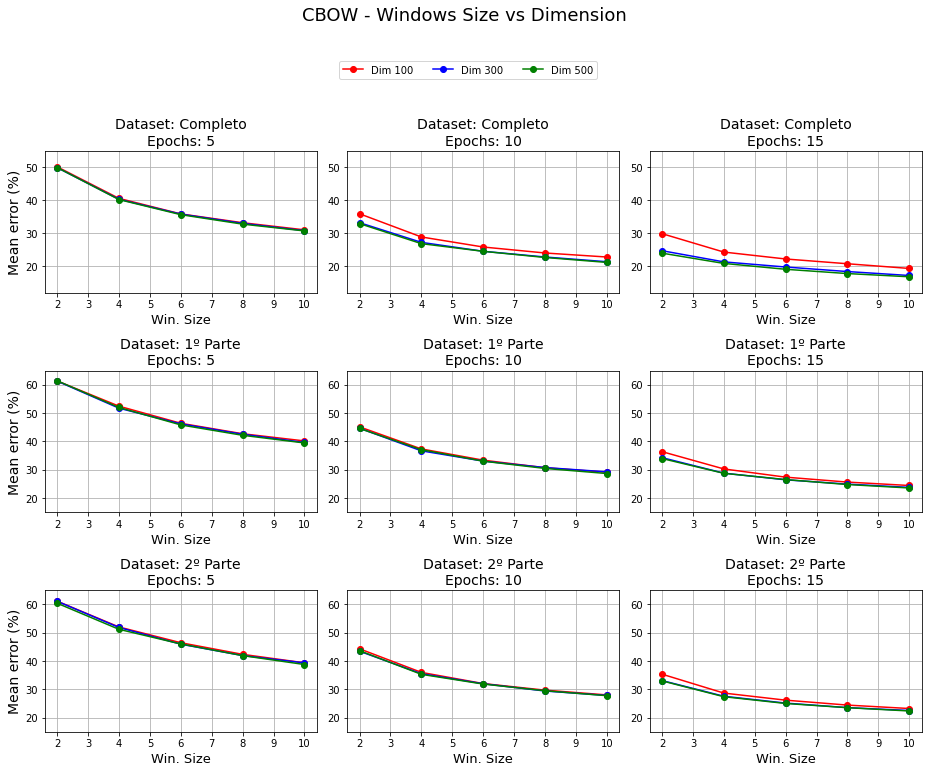

In [239]:
x_axis = [2,4,6,8,10]
line_labels = ['Dim 100', 'Dim 300', 'Dim 500']
col_labels = ['Epochs: 5', 'Epochs: 10', 'Epochs: 15']
dataset_names = ['Dataset: Completo', 'Dataset: 1º Parte', 'Dataset: 2º Parte']
y_range = [[12, 55], [15, 65], [15, 65]]
n_rows = 3
n_cols = 3
main_title = 'CBOW - Windows Size vs Dimension'
x_label = 'Win. Size'

plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label)

## SKIP-GRAM - Windows Size

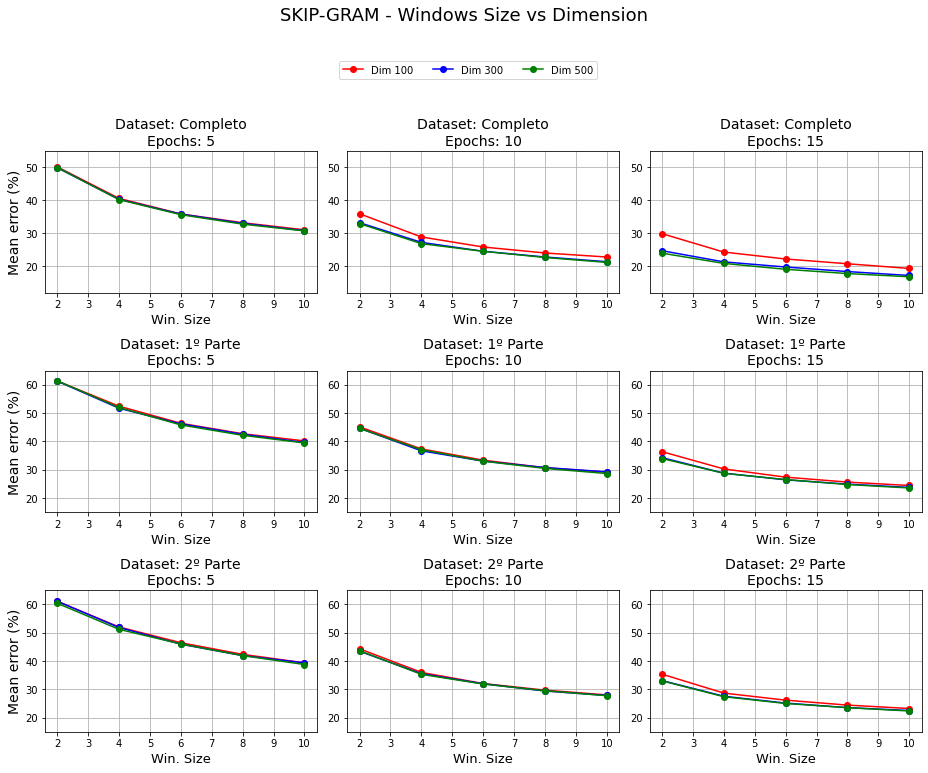

In [36]:
main_title = 'SKIP-GRAM - Windows Size vs Dimension'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label)

# EPOCHS

In [38]:
g_values_cbow = []
g_values_sg = []

for i in range(0, len(DIMENSIONS)):
    for w in WINDOWS:
        for d in DIMENSIONS:
            g_values_cbow.append(get_result_models(['d%s-w%s-e5'%(d,w), 'd%s-w%s-e10'%(d,w), 'd%s-w%s-e15'%(d,w)], df, i, True))
            g_values_sg.append(get_result_models(['d%s-w%s-e5'%(d,w), 'd%s-w%s-e10'%(d,w), 'd%s-w%s-e15'%(d,w)], df, i, False))

all_data-cbow-d100-w2-e5.model
all_data-cbow-d100-w2-e10.model
all_data-cbow-d100-w2-e15.model
all_data-skip_gram-d100-w2-e5.model
all_data-skip_gram-d100-w2-e10.model
all_data-skip_gram-d100-w2-e15.model
all_data-cbow-d300-w2-e5.model
all_data-cbow-d300-w2-e10.model
all_data-cbow-d300-w2-e15.model
all_data-skip_gram-d300-w2-e5.model
all_data-skip_gram-d300-w2-e10.model
all_data-skip_gram-d300-w2-e15.model
all_data-cbow-d500-w2-e5.model
all_data-cbow-d500-w2-e10.model
all_data-cbow-d500-w2-e15.model
all_data-skip_gram-d500-w2-e5.model
all_data-skip_gram-d500-w2-e10.model
all_data-skip_gram-d500-w2-e15.model
all_data-cbow-d100-w4-e5.model
all_data-cbow-d100-w4-e10.model
all_data-cbow-d100-w4-e15.model
all_data-skip_gram-d100-w4-e5.model
all_data-skip_gram-d100-w4-e10.model
all_data-skip_gram-d100-w4-e15.model
all_data-cbow-d300-w4-e5.model
all_data-cbow-d300-w4-e10.model
all_data-cbow-d300-w4-e15.model
all_data-skip_gram-d300-w4-e5.model
all_data-skip_gram-d300-w4-e10.model
all_data-ski

In [39]:
x_axis = [5,10,15]
line_labels = ['Dim 100', 'Dim 300', 'Dim 500']
col_labels = ['Win. size: 2', 'Win. size: 4', 'Win. size: 6', 'Win. size: 8', 'Win. size: 10']
dataset_names = ['Dataset: Completo', 'Dataset: 1º Parte', 'Dataset: 2º Parte']
y_range = [[15, 55], [15, 65], [15, 65]]
n_rows = 3
n_cols = 5
main_title = 'CBOW - Epochs vs Dimensions'
x_label = 'Epochs'

## CBOW - EPOCHS

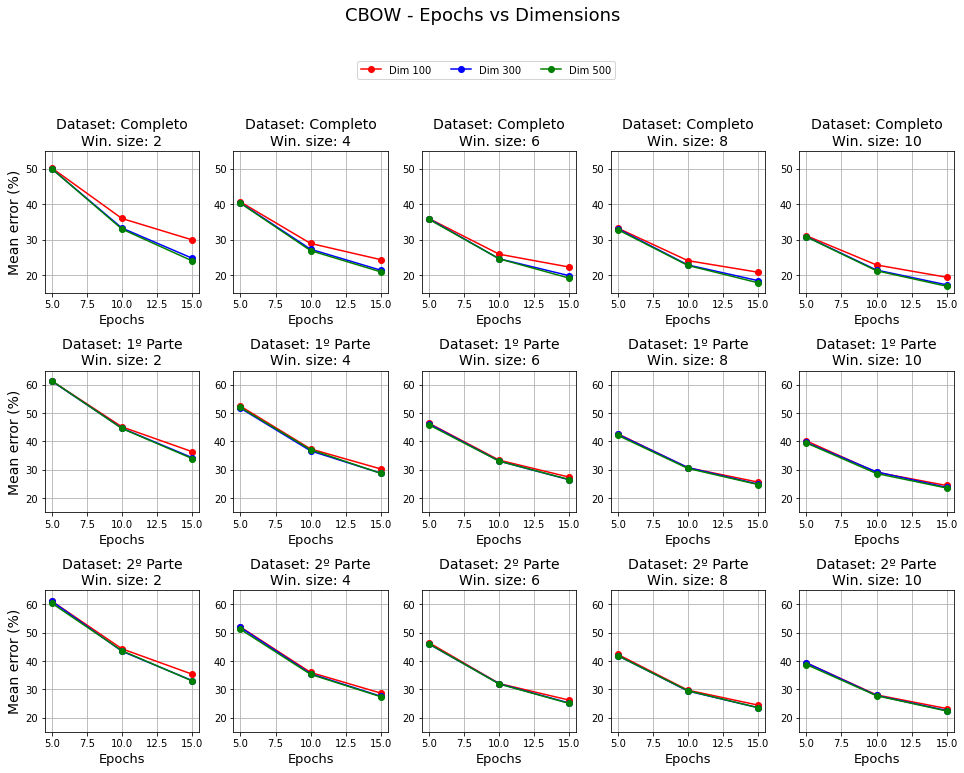

In [41]:
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label, 13.5)

## SKIP-GRAM - EPOCHS

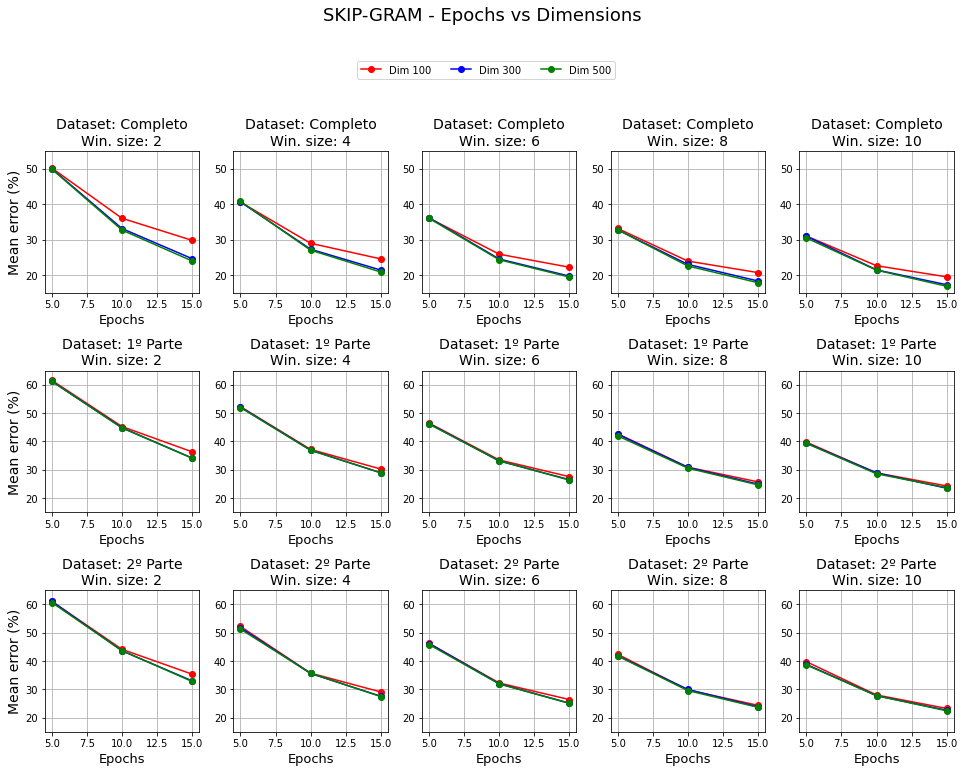

In [42]:
main_title = 'SKIP-GRAM - Epochs vs Dimensions'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_sg, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label, 13.5)

# DIMENSIONS

In [43]:
g_values_cbow = []
g_values_sg = []

for i in range(0, 3):
    for ep in EPOCHS: 
        for w in WINDOWS: 
            g_values_cbow.append(get_result_models(['d100-w%s-e%s'%(w,ep), 'd300-w%s-e%s'%(w,ep), 'd500-w%s-e%s'%(w,ep)], df, i, True))
            g_values_sg.append(get_result_models(['d100-w%s-e%s'%(w,ep), 'd300-w%s-e%s'%(w,ep), 'd500-w%s-e%s'%(w,ep)], df, i, False))

all_data-cbow-d100-w2-e5.model
all_data-cbow-d300-w2-e5.model
all_data-cbow-d500-w2-e5.model
all_data-skip_gram-d100-w2-e5.model
all_data-skip_gram-d300-w2-e5.model
all_data-skip_gram-d500-w2-e5.model
all_data-cbow-d100-w4-e5.model
all_data-cbow-d300-w4-e5.model
all_data-cbow-d500-w4-e5.model
all_data-skip_gram-d100-w4-e5.model
all_data-skip_gram-d300-w4-e5.model
all_data-skip_gram-d500-w4-e5.model
all_data-cbow-d100-w6-e5.model
all_data-cbow-d300-w6-e5.model
all_data-cbow-d500-w6-e5.model
all_data-skip_gram-d100-w6-e5.model
all_data-skip_gram-d300-w6-e5.model
all_data-skip_gram-d500-w6-e5.model
all_data-cbow-d100-w8-e5.model
all_data-cbow-d300-w8-e5.model
all_data-cbow-d500-w8-e5.model
all_data-skip_gram-d100-w8-e5.model
all_data-skip_gram-d300-w8-e5.model
all_data-skip_gram-d500-w8-e5.model
all_data-cbow-d100-w10-e5.model
all_data-cbow-d300-w10-e5.model
all_data-cbow-d500-w10-e5.model
all_data-skip_gram-d100-w10-e5.model
all_data-skip_gram-d300-w10-e5.model
all_data-skip_gram-d500-w1

data2-cbow-d100-w8-e15.model
data2-cbow-d300-w8-e15.model
data2-cbow-d500-w8-e15.model
data2-skip_gram-d100-w8-e15.model
data2-skip_gram-d300-w8-e15.model
data2-skip_gram-d500-w8-e15.model
data2-cbow-d100-w10-e15.model
data2-cbow-d300-w10-e15.model
data2-cbow-d500-w10-e15.model
data2-skip_gram-d100-w10-e15.model
data2-skip_gram-d300-w10-e15.model
data2-skip_gram-d500-w10-e15.model


In [44]:
x_axis = [100,300,500]
line_labels = ['Win. Size 2', 'Win. Size 4', 'Win. Size 6', 'Win. Size 8', 'Win. Size 10']
col_labels = ['Epochs: 5', 'Epochs: 10', 'Epochs: 15']
dataset_names = ['Dataset: Completo', 'Dataset: 1º Parte', 'Dataset: 2º Parte', 't', 't']
y_range = [[12, 55], [15, 65], [15, 65], [15, 50], [15, 45]]
n_rows = 3
n_cols = 3
main_title = 'CBOW - Dimension vs Win. Size'
x_label = 'Dimension'

# CBOW - DIMENSION

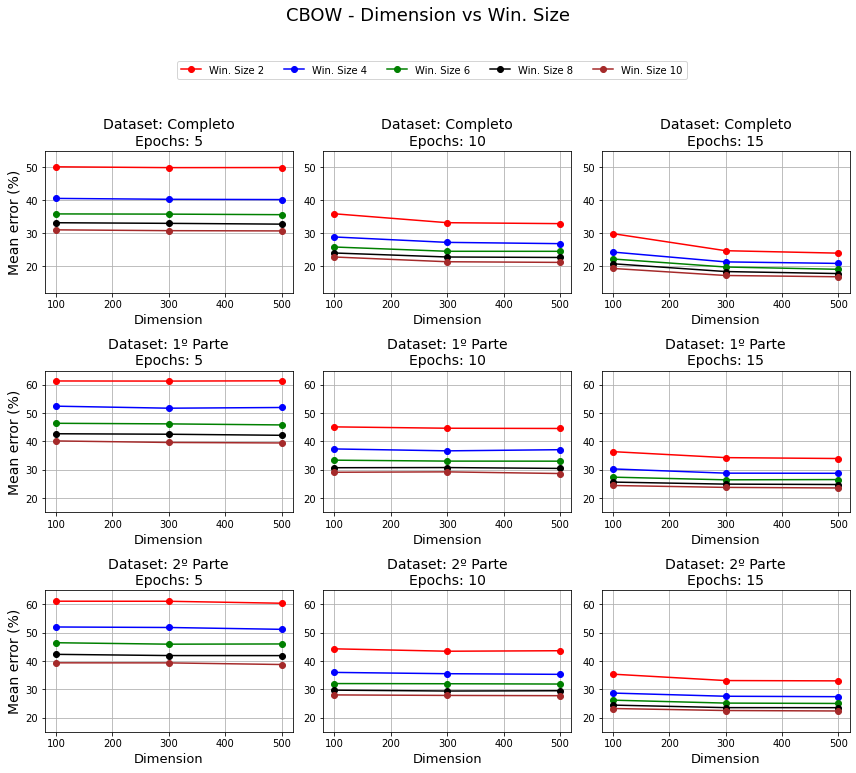

In [45]:
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label, 12, 5)

# SKIP-GRAM DIMENSION

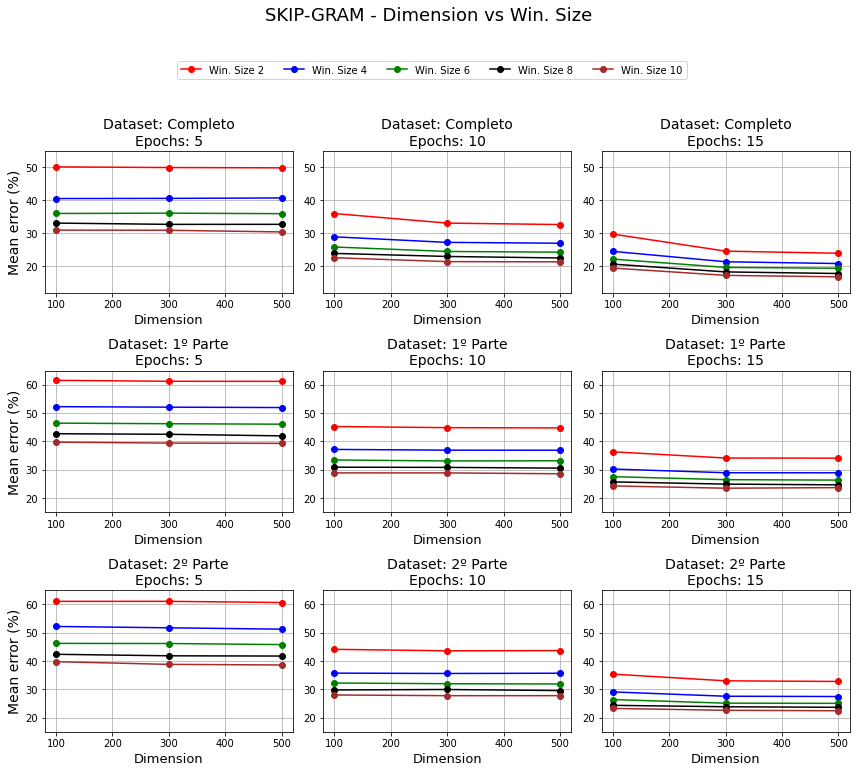

In [46]:
main_title = 'SKIP-GRAM - Dimension vs Win. Size'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_sg, main_title, dataset_names, line_labels, col_labels, y_range, COLORS, x_label, 12, 5)

## Média skip-gram e cbow


In [60]:
df_dataset1 = df.loc[df['model'].str.contains('all_data')]
df_dataset2 = df.loc[df['model'].str.contains('data1')]
df_dataset3 = df.loc[df['model'].str.contains('data2')]

In [49]:
print(np.mean(df.loc[df['model'].str.contains('cbow')]['mean']))
print(np.mean(df.loc[df['model'].str.contains('skip_gram')]['mean']))

0.3390583913554704
0.339157811839621


## média de cada base de dados

In [51]:
me_dataset1 = np.mean(df.loc[df['model'].str.contains('all_data')]['mean'])
me_dataset2 = np.mean(df.loc[df['model'].str.contains('data1')]['mean'])
me_dataset3 = np.mean(df.loc[df['model'].str.contains('data2')]['mean'])

print(me_dataset1, me_dataset2, me_dataset3)

0.28481572476579736 0.3708110716160722 0.3616975084107676


## média para cada win.size

In [53]:
me_win2 = np.mean(df.loc[df['model'].str.contains('-w2-')]['mean'])
me_win4 = np.mean(df.loc[df['model'].str.contains('-w4-')]['mean'])
me_win6 = np.mean(df.loc[df['model'].str.contains('-w6-')]['mean'])
me_win8 = np.mean(df.loc[df['model'].str.contains('-w8-')]['mean'])
me_win10 = np.mean(df.loc[df['model'].str.contains('-w10-')]['mean'])

print(me_win2, me_win4, me_win6, me_win8, me_win10)

0.43297578335428377 0.3601013925158085 0.3232832721979626 0.29867179215377493 0.2805082677658986


## epochs

In [199]:
ep = ['e5', 'e10', 'e15']
y_axis = []

for i in range(0, 3):
    df_local = df_dataset1 if i == 0 else df_dataset2 if i == 1 else df_dataset3
    y_value = []
    #y_value.append(100 - np.mean(df_dataset1.loc[df_dataset1['model'].str.contains(ep[i])]['mean']) * 100)
    #y_value.append(100 - np.mean(df_dataset2.loc[df_dataset2['model'].str.contains(ep[i])]['mean']) * 100)
    #y_value.append(100 - np.mean(df_dataset3.loc[df_dataset3['model'].str.contains(ep[i])]['mean']) * 100)
    
    y_value.append(100 - np.mean(df_local.loc[df_local['model'].str.contains('e5')]['mean']) * 100)
    y_value.append(100 - np.mean(df_local.loc[df_local['model'].str.contains('e10')]['mean']) * 100)
    y_value.append(100 - np.mean(df_local.loc[df_local['model'].str.contains('e15')]['mean']) * 100)
    y_axis.append(y_value)

print(y_axis)

[[61.957129403804714, 73.69348453549617, 78.9046686309599], [51.670757927626795, 65.07026860231309, 72.01565198523846], [52.03625314005391, 66.21577945055158, 73.23871488616426]]


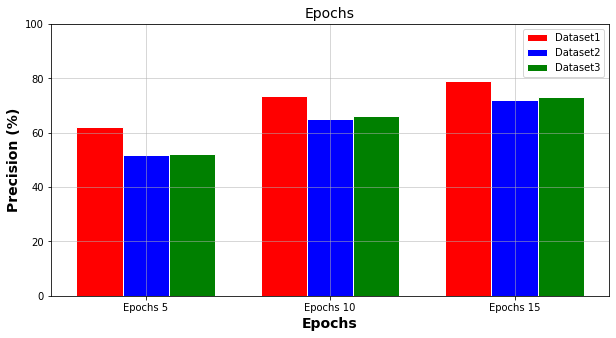

In [202]:

import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
IT = [12, 30, 1]
ECE = [28, 6, 16]
CSE = [29, 3, 24]
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, y_axis[0], color ='red', width = barWidth,
        edgecolor ='white', label ='Dataset1')
plt.bar(br2, y_axis[1], color ='blue', width = barWidth,
        edgecolor ='white', label ='Dataset2')
plt.bar(br3, y_axis[2], color ='green', width = barWidth,
        edgecolor ='white', label ='Dataset3')
 
# Adding Xticks
plt.xlabel('Epochs', fontweight ='bold', fontsize = 14)
plt.ylabel('Precision (%)', fontweight ='bold', fontsize = 14)
plt.xticks([r + barWidth for r in range(len(IT))],
        ['Epochs 5', 'Epochs 10', 'Epochs 15'])

plt.ylim([0, 100])

plt.grid(True, linewidth=0.5)
plt.legend()
plt.title('Epochs', fontsize = 14)
plt.show()

/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


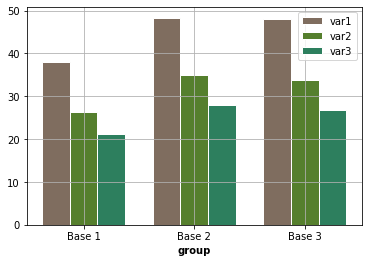

In [135]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = [12, 30, 1]
bars2 = [28, 6, 16]
bars3 = [29, 3, 24]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
ax = fig.add_axes([0,0,1,1])

# Make the plot
plt.bar(r1, y_axis[0], color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, y_axis[1], color='#557f2d', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, y_axis[2], color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Base 1', 'Base 2', 'Base 3'])
 
plt.grid(True)
# Create legend & Show graphic
plt.legend()
plt.show()

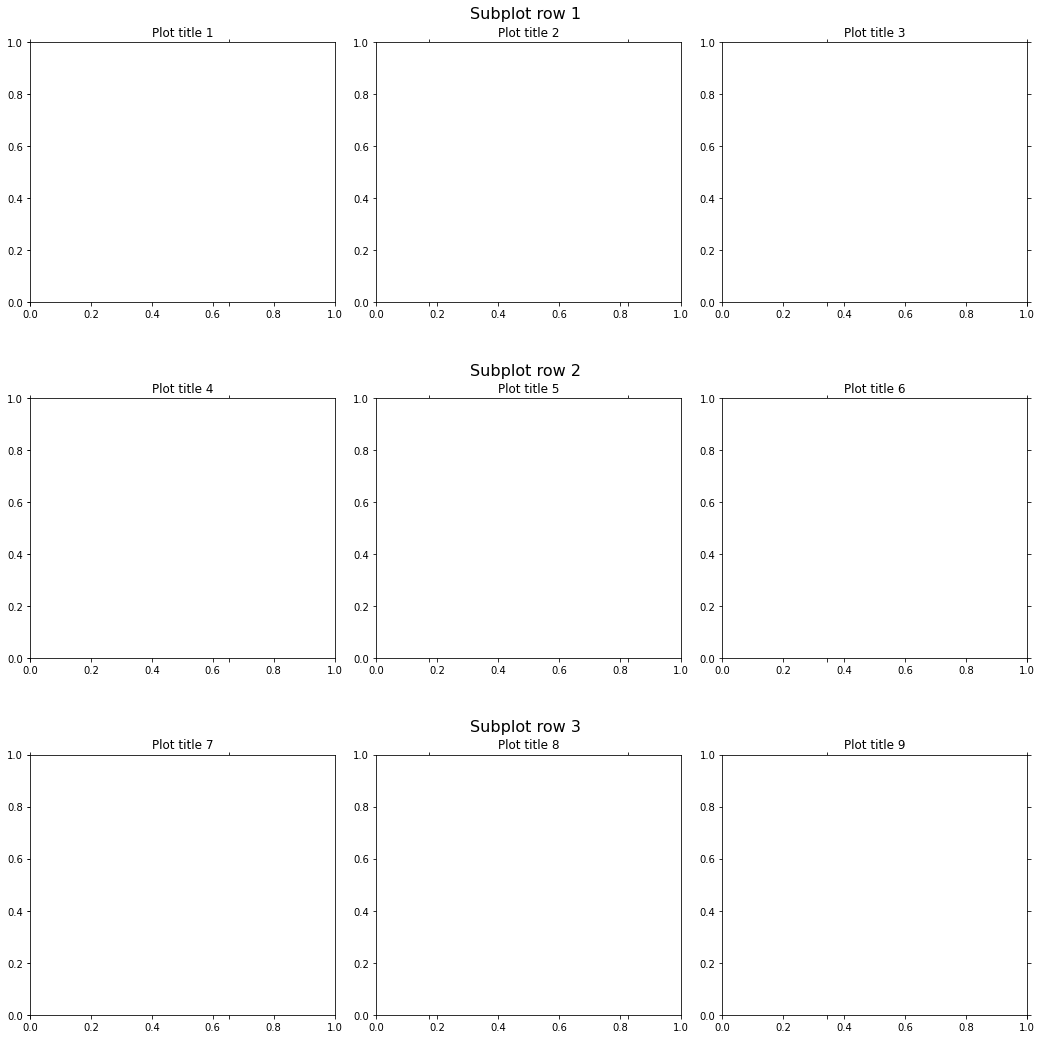

In [235]:
#https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
#https://newbedev.com/row-titles-for-matplotlib-subplot
import matplotlib.pyplot as plt

fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Subplot row %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False


for i in range(1,10):
    ax = fig.add_subplot(3,3,i)
    ax.set_title('Plot title ' + str(i))

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

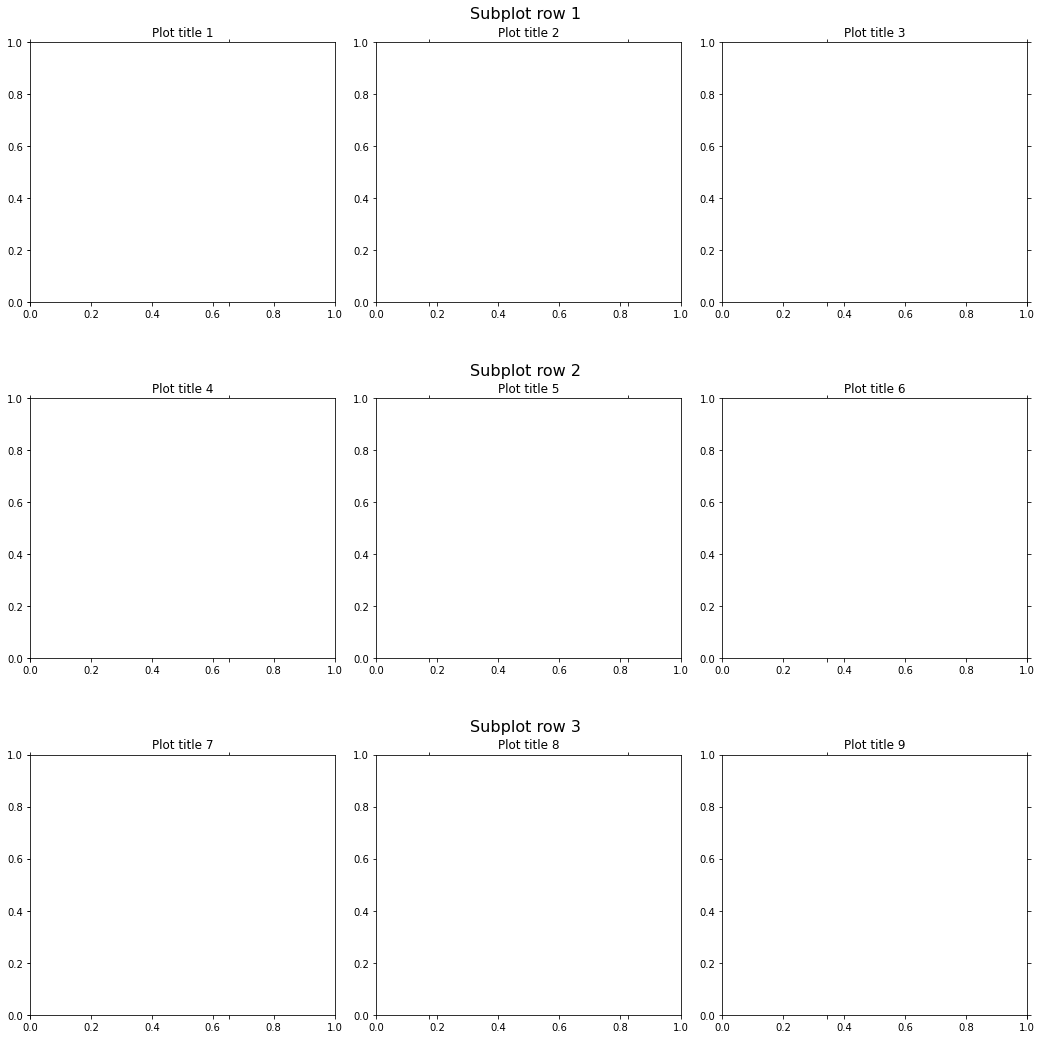

In [234]:
import matplotlib.pyplot as plt

fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Subplot row %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False


for i in range(1,10):
    ax = fig.add_subplot(3,3,i)
    ax.set_title('Plot title ' + str(i))

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

# CBOW e SKIP vs Windows

In [557]:
#incluir

# Conclusão

### OLD

In [2]:
dataset = api.load("text8")

data = []
for word in dataset:
    data.append(word)

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
model = Word2Vec(data,
                                min_count=1,
                                sg = 0, #skip-gram or cbow
                                window = 6, #window size
                                vector_size = 300, #dimensionality
                                hs = 0, #use negative sampling
                                negative = 5, #number sampling
                                epochs = 20,
                                workers=cpu_count())

2021-12-07 22:05:35,798 : INFO : collecting all words and their counts
2021-12-07 22:05:35,799 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-07 22:05:37,639 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2021-12-07 22:05:37,639 : INFO : Creating a fresh vocabulary
2021-12-07 22:05:38,319 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 253854 unique words (100.0%% of original 253854, drops 0)', 'datetime': '2021-12-07T22:05:38.319828', 'gensim': '4.1.2', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-90-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-12-07 22:05:38,320 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 17005207 word corpus (100.0%% of original 17005207, drops 0)', 'datetime': '2021-12-07T22:05:38.320268', 'gensim': '4.1.2', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[

2021-12-07 22:06:07,356 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-12-07 22:06:07,375 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-12-07 22:06:07,376 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-12-07 22:06:07,377 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-12-07 22:06:07,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-07 22:06:07,392 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-07 22:06:07,393 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-07 22:06:07,394 : INFO : EPOCH - 3 : training on 17005207 raw words (12819345 effective words) took 8.5s, 1504046 effective words/s
2021-12-07 22:06:08,398 : INFO : EPOCH 4 - PROGRESS: at 10.58% examples, 1347375 words/s, in_qsize 22, out_qsize 1
2021-12-07 22:06:09,405 : INFO : EPOCH 4 - PROGRESS: at 22.69% examples, 1444072 words/s, in_qsize 23, out_q

2021-12-07 22:06:43,503 : INFO : EPOCH 7 - PROGRESS: at 91.65% examples, 1458540 words/s, in_qsize 21, out_qsize 2
2021-12-07 22:06:44,138 : INFO : worker thread finished; awaiting finish of 11 more threads
2021-12-07 22:06:44,151 : INFO : worker thread finished; awaiting finish of 10 more threads
2021-12-07 22:06:44,154 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-12-07 22:06:44,155 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-12-07 22:06:44,158 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-12-07 22:06:44,169 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-12-07 22:06:44,175 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-12-07 22:06:44,181 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-12-07 22:06:44,183 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-12-07 22:06:44,189 : INFO : worker thread finished; awaitin

KeyboardInterrupt: 

In [4]:
count = 0
text = ""
with open("data/text8", 'r') as infile:
    for line in infile:
        text = process_text(line)
        
        count = + 1

In [6]:
print(text[0:50])

 anarchism originated astermabuse first usedearly 


In [6]:
sentences = word2vec.Text8Corpus('data/text8')

In [ ]:
model = Word2Vec(sentences, min_count=5)

In [36]:
model.wv.most_similar("good")

[('bad', 0.7443740963935852),
 ('poor', 0.5743762254714966),
 ('quick', 0.5488086342811584),
 ('reasonable', 0.5429285764694214),
 ('safe', 0.5324724912643433),
 ('little', 0.5284340381622314),
 ('clever', 0.5271481275558472),
 ('wrong', 0.5259556770324707),
 ('fun', 0.5209583044052124),
 ('simple', 0.5187517404556274)]

In [43]:
model.wv.most_similar(negative=['man', 'women'], positive=['king'], topn=10)

[('kiev', 0.4300565719604492),
 ('carta', 0.4149296283721924),
 ('brabant', 0.4144781827926636),
 ('umayyad', 0.40684974193573),
 ('iii', 0.39912277460098267),
 ('ducal', 0.394608736038208),
 ('cordoba', 0.39357495307922363),
 ('hohenstaufen', 0.39350447058677673),
 ('abdicates', 0.3897632956504822),
 ('achaemenid', 0.38964521884918213)]

In [29]:
model.wv.similarity('king', 'queen')

0.66290057

### old graph

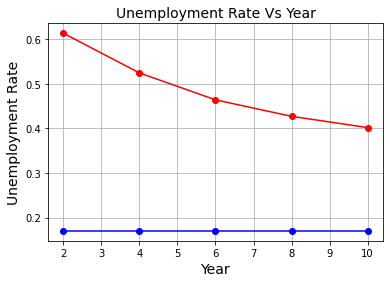

In [20]:
window_size = [2,4,6,8,10]
#results_1 = [38,37,30,29,32]
#results_2 = [35,30,28,27,25]
results_1 = v1
results_2 = [0.17, 0.17, 0.17, 0.17, 0.17]
%matplotlib inline

plt.plot(window_size, results_1, color='red', marker='o')
plt.plot(window_size, results_2, color='blue', marker='o')
plt.title('Unemployment Rate Vs Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate', fontsize=14)
plt.grid(True)
plt.show()
plt.close() 